In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# <center>Бейзлайн на Vowpal Wabbit

## Загрузка данных

In [2]:
df = pd.read_csv('X_train.csv', parse_dates=['date'])

In [3]:
df.shape

(15587, 11)

In [4]:
df.head()

,sku,categoryLevel1Id,categoryLevel2Id,brandId,property,userName,reting,date,comment,commentNegative,commentPositive
0,20005023,401,4010201,826,"[{34: 'f982777489055c6563d68c005fd24aad'}, {36...",b2898a81b45310b30beb8fc0c0a9ce1e,2.0,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",NaN,NaN
1,20020647,403,4030101,1425,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",538c73d64461e13907bb95c51c38bfbc,2.0,2010-07-04,Через 2 месяца после истечении гарантийного ср...,NaN,NaN
2,20020701,401,4010401,124,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",ddca2d0101513a6209db7868eed8be05,4.0,2010-05-27,пользуюсь уже три недели. нареканий ни каких н...,NaN,NaN
3,30012256,203,2030301,93,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",289c20015b3713a82ba5ddf774d996f7,5.0,2016-10-11,Ребят этот системный блок подойдёт для игры кс...,NaN,NaN
4,30011341,205,2050201,656,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",5576f82d149d4f688644fef2322c63ef,5.0,2010-02-26,"я считаю, что яри замечательный телефон! Прият...",NaN,NaN


Целевая переменная - **reting**, посмотрим на её значения

In [5]:
df.reting.value_counts()

5.0    9211
4.0    2609
1.0    1468
3.0    1245
2.0     854
4.7      78
4.3      54
3.7      16
3.3      16
2.7      15
2.3      14
1.3       6
1.7       1
Name: reting, dtype: int64

Как видно, дробных значений совсем мало, округлим их до целых

In [6]:
df.reting = df.reting.apply(lambda x: round(x))

Посмотрим на распределение значений

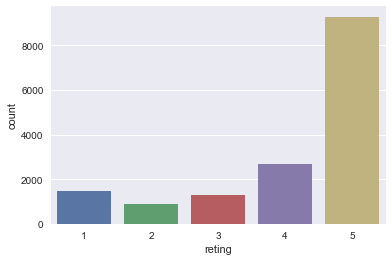

In [7]:
sns.countplot(df.reting);

In [8]:
df.reting.value_counts(normalize=True)

5    0.595945
4    0.171874
1    0.094566
3    0.081863
2    0.055752
Name: reting, dtype: float64

Положительных отзывов в данных намного больше отрицательных. Если просто предсказывать всегда 5, то получим долю правильных ответов около 0.59

## Приведение к формату Vowpal Wabbit

Функция для "очистки" текста отзыва

In [9]:
def clean_text(text):
    # привести к нижнему регистру
    text = text.lower()
    # заменить точки, запятые и пр. на пробелы
    text = re.sub(r'[\.,:;\|]', r' ', text)
    # добавить пробелы по обе стороны от воскл. и вопр. знаков и скобок
    text = re.sub(r'([!?\(\)])', r' \g<1> ', text)  
    # заменить множественные пробелы на одиночные
    text = re.sub(r'(\s){2,}', r'\g<1>', text)
    return text

Почистим текстовые данные

In [10]:
for col in ['comment', 'commentNegative', 'commentPositive']:
    df[col].fillna(' ', inplace=True)
    df[col] = df[col].apply(lambda x: clean_text(x))

Преобразуем данные к формату vowpal wabbit

In [11]:
data_vw = (df.reting.astype(str) +
           ' |comment ' + df.comment +
           ' |comneg ' + df.commentNegative +
           ' |compos ' + df.commentPositive + 
           ' |sku ' + df.sku.astype(str) +
           ' |level1 ' + df.categoryLevel1Id.astype(str) +
           ' |level2 ' + df.categoryLevel2Id.astype(str) +
           ' |brand ' + df.brandId.astype(str))

Разобьем на обучение и тест по целевой переменной (70% - train, 30% - test)

In [12]:
train_vw, test_vw, y_train, y_test = train_test_split(data_vw, df.reting, test_size=0.3,
                                                      stratify=df.reting, random_state=19)

Запишем данные для обучения и теста в train.vw и test.vw

In [13]:
with open('train.vw', 'w') as f:
    print(*train_vw.values, sep='\n', file=f)

In [14]:
with open('test.vw', 'w') as f:
    print(*test_vw.values, sep='\n', file=f)

## Обучение и оценка модели

Обучим модель с биграммами текстовых признаков и логистической функцией потерь

In [15]:
!vw --oaa 5 --passes 1 -d train.vw -f model.vw -b 26 \
    --random_seed 19 -c -k --ngram c2 \
    --loss_function logistic

Generating 2-grams for c namespaces.
final_regressor = model.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
creating cache_file = train.vw.cache
Reading datafile = train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        1        1       94
0.000000 0.000000            2            2.0        1        1       60
0.500000 1.000000            4            4.0        4        1       22
0.625000 0.750000            8            8.0        5        5       34
0.437500 0.250000           16           16.0        5        5      116
0.468750 0.500000           32           32.0        4        5       50
0.453125 0.437500           64           64.0        1        5      112
0.445312 0.437500          128          128.0        2        5       64
0.414062 0.382812          256          256.0        5  

Предскажем целевую переменную для тестового датасета

In [16]:
!vw -i model.vw -t -d test.vw -p y_pred.txt

Generating 2-grams for c namespaces.
only testing
predictions = y_pred.txt
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        5        5      140
0.000000 0.000000            2            2.0        2        2       64
0.250000 0.500000            4            4.0        1        1      136
0.250000 0.250000            8            8.0        5        5       42
0.312500 0.375000           16           16.0        5        4      368
0.281250 0.250000           32           32.0        5        4      162
0.265625 0.250000           64           64.0        4        5      256
0.273438 0.281250          128          128.0        4        5       34
0.343750 0.414062          256          256.0        5        5     

Посмотрим на качество

In [17]:
y_pred = np.loadtxt('y_pred.txt', dtype=int)
accuracy_score(y_test, y_pred)

0.66581141757536888

Доля верных ответов **0.66**, что лучше качества самого простого и бесполезного решения "все 5" в 0.59

Посмотрим на confusion matrix

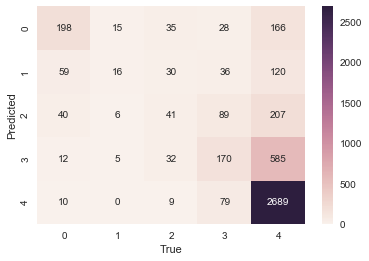

In [20]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('True')
plt.ylabel('Predicted');

Больше всего модель путает 5 и 4 и плохо предсказывает средние значения